## Introduction

Over the last decade, data science techniques and data analysts have chewed up professional basketball and spit out an almost entirely new game. As you may not know, 
the NBA is actually the first US sports league to let data into the locker room. And nearly every team in the NBA now has data analysts on their staff who work with coaches and player evaluators to maximize individual athlete’s talents and identify undervalued players. For example, one of current NBA’s best team, the defending champion Golden State Warriors, credit much of their success to their analytics acumen.

    (Graph exploring Warriors' shooting efficiency on each poit of the court.)
<img src="nba-with-data-science_Warrior_Defence.png">

The league even runs an annual Hackathon to uncover new data analyst talent. And you can find position of data scientist for NBA on websites like Glassdor. 
In summary, nowadays data science has gone deep into all aspects of the NBA, letting teams and players better analyze and prepare for the games.

The purpose of this tutorial is to demonstrate a basic process for obtaining, processing, and analyzing NBA datasets. First we will gather some 2017-18 NBA Season Summary official datasets for each team. Then after truncating and preprocessing the raw data, it will be utilized to calculate the Elo Score of each team. Finally, we are going to apply k-means clustering method to partition and group all NBA's 30 teams into clusters in order to evaluate their competence level.

### Tutorial Content
In this tutorial, I will show how to do some simple analysis on NBA teams' season performance based on Elo ranking system and k-means clustering method.

The datasets are collected from a popular sports statistics website 'Basketball Reference': https://www.basketball-reference.com.

Following topics are covered in this tutorial:
- [Libraries involved](#Libraries-involved)
- [Data collecting and preprocessing](#Data-collecting-and-preprocessing)
    * [Brief introduction about the datasets](#Brief-introduction)
    * [Generate season schedules and results](#Generate-season-schedules-and-results)
    * [Truncate and merge major stats tables](#Truncate-and-merge-major-stats-tables)
- [Elo Rating System](#Elo-Rating-System)
    * [Background and Theory](#Background-and-Theory)
    * [Compute each team's Elo Score](Compute-each-team's-Elo-Score)
- [K-means Clustering algorithm](#K-means-Clustering-algorithm)
    * [Brief introduction](#Brief-introduction)
    * [Clustering with two major attributes](#Clustering-with-two-major-attributes)
    * [Clustering with all attributes](#Clustering-with-all-attributes)
- [Summary and references](#Summary-and-references)

## Libraries involved

All libraries used here are thoese we have been palying with by far, like 'Numpy' for matrices and vectors operations, 'Pandas' for data frame, 'Matplotlib' for visualization and I choose Scikit Learn library to handle k-means method.

In [5]:
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

## Data collecting and preprocessing

### Brief introduction about the datasets

During a regular NBA game, a variety of statistics have been recorded in detail. Beginning in 2009, the league began using a video system that tracked the movement of every player on the court, and the ball, 25 times a second. And all the data collected is safely stored in the official database, meaning that you can just go to http://stats.nba.com/ and easily check the stats of the 50s, digitally viewing the dominant performance of ancient beasts such as George McCann.

For this tutorial, we can scrap the data from http://stats.nba.com/. However, data tables on the website are actually well organized, and there are multiple tables needed to be gathered. So in order not to let redundant scraping code take up lots of lines, we can simply get CSV format of these datasets from "Basketball-refernce.com".

For example, in the 2017-2018 Season Summary page of the site, you can locate the 'Team per Game Stats' form, clicking 'Share & more' field, and then you will be able to download it by Selecting 'Get table as CSV (for Excel)' from the drop-down menu.

<img src="Download-CSV-from-Basketball-Reference.png">

Since the goal here is to evaluate all teams' competence level for this season, we will use three team stats tables: 
    1. Team Per Game Stats (Abbreviated as table T)
    2. Opponent Per Game Stats (Abbreviated as table O)
    3. Miscellaneous Stats (Abbreviated as table M)
to constitute each team's feature vector.
And all game schedules and results(From October 2017 to March 2018) for the season so far are also needed, as input datasets for Elo Score calculation step.

### Generate season schedules and results

So far, all teams have finished around 72 regular season games(82 games in total). So we need to get all game schedules from October 2017 to March 2018.

In [6]:
game_Schedules = ['2017-18_NBA_Schedule_and_Results_October.csv', '2017-18_NBA_Schedule_and_Results_November.csv', '2017-18_NBA_Schedule_and_Results_December.csv', '2017-18_NBA_Schedule_and_Results_January.csv', '2017-18_NBA_Schedule_and_Results_February.csv', '2017-18_NBA_Schedule_and_Results_March.csv' ]

It is worth mentioning that all data used in this tutorial are generated from 72 games by now, instead of whole season records. But I think it won't cause too much interference with subsequent analysis. Because at this time of the season, playoff seats and matchup have been established, for the top teams, they have already rested their major players in rotation, and for those bottom ranked teams, most of them have decided to 'tanking'[http://www.espn.com/nba/story/_/id/22554035/2018-nba-draft-tank-race-win-best-lottery-odds]. That is to say, games near the end of the season may not show the real strength of each team.

In [7]:
raw_October_schedule = pd.read_csv('2017-18_NBA_Schedule_and_Results_October.csv')
raw_October_schedule.head()

,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 6,Unnamed: 7,Attend.,Notes
0,Tue Oct 17 2017,8:01 pm,Boston Celtics,99,Cleveland Cavaliers,102,Box Score,NaN,20562,NaN
1,Tue Oct 17 2017,10:30 pm,Houston Rockets,122,Golden State Warriors,121,Box Score,NaN,19596,NaN
2,Wed Oct 18 2017,7:30 pm,Milwaukee Bucks,108,Boston Celtics,100,Box Score,NaN,18624,NaN
3,Wed Oct 18 2017,8:30 pm,Atlanta Hawks,117,Dallas Mavericks,111,Box Score,NaN,19709,NaN
4,Wed Oct 18 2017,7:00 pm,Charlotte Hornets,90,Detroit Pistons,102,Box Score,NaN,20491,NaN


Here we need to combine the 6 tables together and extract the winner and loser for each game, along with 'H/V' column indicating whether the winner is visitor team or home team.

In [8]:
def process_Schedule_Result(schedules):
    """ Combine and Process game schedules from 2017.10 to 2018.03 
    
    Args:
        schedules (list): list of CSV file path for each month's  game schedule and results
        
    Returns:
        (pd.DataFrame): DataFrame of all regular season games' result by far
    
    """
    raw_Schedule = pd.DataFrame()
    for schedule in schedules:
        # Read CSV files into DataFrame
        # na_filter will detect missing value markers
        temp = pd.read_csv(schedule, names=['Date', 'Start', 'Visitor_Team', 'V_PTS', 'Home_Team', 'H_PTS', 'X', 'XX', 'Attend.', 'Notes'], header = 0, na_filter=False)
        temp.drop(['Date', 'Start', 'X', 'XX', 'Attend.', 'Notes'], axis=1, inplace=True)
        raw_Schedule = raw_Schedule.append(temp)
        
    raw_Schedule.reset_index(inplace=True, drop=True)
    
    # Figure out Winner Team and Loser Team, Generate Game Results
    Team_Win = []
    Team_Lose = []
    H_V = []
    for i in range(0, raw_Schedule.shape[0]):
        if(raw_Schedule.iloc[i, 1] > raw_Schedule.iloc[i,3]):
            Team_Win.append(raw_Schedule.iloc[i, 0])
            Team_Lose.append(raw_Schedule.iloc[i, 2])
            H_V.append('V')
        else:
            Team_Win.append(raw_Schedule.iloc[i, 2])
            Team_Lose.append(raw_Schedule.iloc[i, 0])
            H_V.append('H')
    
    res = pd.DataFrame({'H/V' : H_V, 'Team_Win' : Team_Win, 'Team_Lose' : Team_Lose})
    return res

game_Results = process_Schedule_Result(game_Schedules)
game_Results

,H/V,Team_Lose,Team_Win
0,H,Boston Celtics,Cleveland Cavaliers
1,V,Golden State Warriors,Houston Rockets
2,V,Boston Celtics,Milwaukee Bucks
3,V,Dallas Mavericks,Atlanta Hawks
4,H,Charlotte Hornets,Detroit Pistons
5,H,Brooklyn Nets,Indiana Pacers
6,H,New Orleans Pelicans,Memphis Grizzlies
7,H,Miami Heat,Orlando Magic
8,V,Phoenix Suns,Portland Trail Blazers
9,V,Sacramento Kings,Houston Rockets


Now we have the matchup and results for 1102 regular season games by far. We mark this table as 'game_Results', and it will be used soon in the next section.

### Truncate and merge major stats tables

For three major team stats tables:
    * Team Per Game Stats table shows teams' average basic statistics per game, including its Field Goal Percentage(FG%), 3-Point Field Goal Percentage(3P%), Total Rebounds(TRB), Turnovers(TOV)... 
    In a word, this table is mainly suitable for measuring the offensive ability of the team.
    

In [9]:
raw_TPGS = pd.read_csv('2017-18_NBA_Team_Per_Game_Stats.csv', na_filter=False)
raw_TPGS.head()

,Rk,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Houston Rockets*,75,241.0,39.1,84.6,0.462,15.5,42.5,0.365,...,0.785,9.1,34.5,43.6,21.8,8.6,4.8,13.8,19.6,113.6
1,2,Golden State Warriors*,74,240.7,42.9,85.1,0.504,11.4,29.1,0.392,...,0.813,8.6,35.3,43.9,29.6,8.0,7.7,15.5,19.8,114.0
2,3,Toronto Raptors*,75,241.7,41.3,87.5,0.473,11.9,32.8,0.362,...,0.797,9.8,33.8,43.6,24.2,7.8,6.1,13.3,21.7,112.5
3,4,New Orleans Pelicans,75,243.7,42.5,88.2,0.481,10.1,28.1,0.359,...,0.772,8.7,35.5,44.2,26.4,7.7,5.9,14.9,19.1,111.3
4,5,Denver Nuggets,75,241.7,40.6,86.4,0.470,11.6,30.9,0.375,...,0.765,10.9,33.2,44.1,25.0,7.9,4.8,15.1,18.5,109.7


    * Opponent Per Game Stats table shows this team's opponents' average statistics per game, containing statistics consistent with those in Team Per Game Stats table, except represent the corresponding opponents of the team.
    So this table can serve as indicator of the team's deffensive competence.

In [10]:
OPGS = pd.read_csv('2017-18_NBA_Opponent_Per_Game_Stats.csv', na_filter=False)
OPGS.head()

,Rk,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Utah Jazz,74,241.0,37.4,82.9,0.451,9.6,26.4,0.366,...,0.772,8.6,33.2,41.9,20.0,8.3,4.7,14.9,20.5,100.2
1,2,Boston Celtics*,74,241.7,37.2,85.1,0.437,9.2,27.2,0.339,...,0.764,9.7,34.1,43.8,20.8,7.2,4.4,14.0,18.9,100.2
2,3,San Antonio Spurs,75,240.3,38.1,84.3,0.452,9.2,26.5,0.347,...,0.758,9.2,33.2,42.3,21.8,7.7,3.9,14.1,19.6,99.4
3,4,Portland Trail Blazers,74,241.0,38.4,85.9,0.447,9.7,26.6,0.364,...,0.764,9.3,33.4,42.7,20.2,7.3,5.1,12.6,19.2,103.2
4,5,Detroit Pistons,74,241.4,38.9,84.9,0.458,11.0,30.4,0.361,...,0.778,9.2,34.6,43.9,24.9,7.3,5.0,14.9,18.4,103.8


    * Miscellaneous Stats table provides comprehensive statistics for each team, including some advanced data like True Shooting Percentage(TS%), which is measure of shooting efficiency that takes into account 2-point field goals, 3-point field goals, and free throws.
    So I think it will be necessary to take these advanced data into consideration when constructing team's feature vectors.

In [11]:
raw_MS = pd.read_csv('2017-18_NBA_Miscellaneous_Stats.csv', header=1, na_filter=False)
raw_MS.head()

,Rk,Team,Age,W,L,PW,PL,MOV,SOS,SRS,...,TOV%,ORB%,FT/FGA,eFG%.1,TOV%.1,DRB%,FT/FGA.1,Arena,Attend.,Attend./G
0,1,Houston Rockets*,29.8,61,14,58,17,9.41,-0.23,9.19,...,12.6,21.6,0.235,0.522,13.4,79.9,0.171,Toyota Center,660502,17851
1,2,Toronto Raptors*,25.9,55,20,55,20,8.05,-0.60,7.45,...,12.0,23.3,0.204,0.504,13.3,77.2,0.212,Air Canada Centre,753596,19831
2,3,Golden State Warriors*,28.9,54,20,52,22,7.00,-0.04,6.96,...,14.1,21.5,0.197,0.500,12.5,76.4,0.188,Oracle Arena,744648,19596
3,4,Boston Celtics*,24.7,51,23,47,27,4.05,-0.45,3.60,...,12.9,21.2,0.186,0.491,12.9,78.5,0.195,TD Garden,689088,18624
4,5,Utah Jazz,26.8,42,32,45,29,3.34,0.14,3.47,...,13.7,21.1,0.203,0.509,14.0,79.8,0.190,Vivint Smart Home Arena,643276,17869


Then we need to load these major tables, readjusting original table headers and footers, dropping irrelevant or missleading attributes like Rank(Rk), Arena, Age, Attend ... finally merge three tables together on 'Team' column.

In [12]:
def process_Game_Stats():
    """ PreProcess and merge tables T, O and M, building feature vectors for each team 
        
    Returns:
        (pd.DataFrame): DataFrame of all NBA's 30 teams major statistics data related to the team's competence
    
    """
    TPGS = pd.read_csv('2017-18_NBA_Team_Per_Game_Stats.csv', na_filter=False)
    OPGS = pd.read_csv('2017-18_NBA_Opponent_Per_Game_Stats.csv', na_filter=False)
    MS = pd.read_csv('2017-18_NBA_Miscellaneous_Stats.csv', header=1, na_filter=False)
    # Drop Irrelevant or Missleading Columns
    TPGS.drop(['Rk', 'G', 'MP'], axis=1, inplace=True)
    TPGS.drop(30, axis=0, inplace=True)
    OPGS.drop(['Rk', 'G', 'MP'], axis=1, inplace=True)
    OPGS.drop(30, axis=0, inplace=True)
    MS.drop(['Rk', 'Age', 'Arena', 'Attend.', 'Attend./G'], axis=1, inplace=True)
    MS.drop(30, axis=0, inplace=True)
    MS[['W','L']] = MS[['W','L']].astype('int64')


    # For Better Merge After
    OPGS.rename(columns=lambda x:"OP_"+x, inplace=True)
    OPGS.rename(columns={'OP_Team' : 'Team'}, inplace=True)
    
    # Merge Tables
    Team_Stats = pd.merge(TPGS, OPGS, how='left', on='Team')
    Team_Stats = Team_Stats.merge(MS, how='left', on='Team')
    
    return Team_Stats
    
Team_Official_Stats = process_Game_Stats()
# print(Team_Official_Stats.columns)
Team_Official_Stats

,Team,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,...,3PAr,TS%,eFG%,TOV%,ORB%,FT/FGA,eFG%.1,TOV%.1,DRB%,FT/FGA.1
0,Houston Rockets*,39.1,84.6,0.462,15.5,42.5,0.365,23.6,42.1,0.560,...,0.502,0.593,0.554,12.6,21.6,0.235,0.522,13.4,79.9,0.171
1,Golden State Warriors*,42.9,85.1,0.504,11.4,29.1,0.392,31.5,56.1,0.562,...,0.342,0.605,0.571,14.1,21.5,0.197,0.500,12.5,76.4,0.188
2,Toronto Raptors*,41.3,87.5,0.473,11.9,32.8,0.362,29.5,54.7,0.539,...,0.375,0.578,0.541,12.0,23.3,0.204,0.504,13.3,77.2,0.212
3,New Orleans Pelicans,42.5,88.2,0.481,10.1,28.1,0.359,32.4,60.1,0.538,...,0.318,0.571,0.539,13.3,19.9,0.185,0.515,12.4,76.8,0.178
4,Denver Nuggets,40.6,86.4,0.470,11.6,30.9,0.375,29.1,55.6,0.523,...,0.357,0.571,0.537,13.6,25.5,0.196,0.544,12.9,77.7,0.173
5,Minnesota Timberwolves,41.0,85.8,0.478,8.0,22.3,0.358,33.1,63.5,0.521,...,0.260,0.568,0.525,11.5,24.5,0.229,0.541,13.8,76.2,0.188
6,Cleveland Cavaliers*,40.4,84.6,0.477,11.9,32.4,0.368,28.4,52.2,0.545,...,0.383,0.584,0.547,12.8,20.0,0.213,0.539,12.2,76.9,0.169
7,Los Angeles Clippers,40.3,85.5,0.471,9.9,27.8,0.357,30.4,57.7,0.526,...,0.325,0.567,0.529,13.2,23.1,0.223,0.517,12.8,76.1,0.204
8,Charlotte Hornets,38.9,87.0,0.447,9.9,27.0,0.368,28.9,60.0,0.482,...,0.310,0.545,0.504,11.2,22.3,0.231,0.532,12.7,81.0,0.170
9,Oklahoma City Thunder,39.9,87.8,0.455,10.5,29.8,0.352,29.4,57.9,0.508,...,0.340,0.546,0.515,12.5,27.7,0.192,0.524,14.7,77.2,0.192


Now we have all major stats for 30 teams set up, marked as 'Team_Official_Stats'.The DataFrame contains features(64 in total) measuring the offensive and defensive strength of each team. 

## Elo Rating System

### Background and Theory

Notice that in the feature vectors generated above, the 'W' column stores the wins of each team throughout the season. However, in the game of basketball, or for most competitive sports, the number of wins does not fully reflect the competitiveness of a team. 

Suppose team A and team B both have won 45 games, and A has a better record against teams ranked higher in the league, but it lost more games against bottom ranking teams than B due to schedules(intensive back-to-back games) or player injuries. At this point it's hard to rank A and B merely based on the number of wins.

So I will introduce ELO rating system here to rate the 30 teams more scientifically.

The Elo system was originally invented as an improved chess rating system, but is also used as a rating system for multiplayer competition in a number of video games,football, basketball, Major League Baseball, board games such and other games.

<img src="Chess-Game.jpg">

A player's Elo rating is represented by a number which increases or decreases depending on the outcome of games between rated players. After every game, the winning player takes points from the losing one. The difference between the ratings of the winner and loser determines the total number of points gained or lost after a game. In a single game between a high-rated player and a low-rated player, the high-rated player is expected to score more points. 

If Player A has a rating of $R_A$ and Player B a rating of $R_B$, the exact formula for the expected score of Player A is:

$$ E_A = \frac{1}{1 + 10^{(R_B-R_A)/400}} $$

Similarly the expected score for Player B is: 

$$ E_B = \frac{1}{1 + 10^{(R_A-R_B)/400}} $$


If the high-rated player wins, then only a few rating points will be taken from the low-rated player. However, if the lower rated player scores an upset win, many rating points will be transferred.(Because the low-rated player has a lower probability to win)The lower rated player will also gain a few points from the higher rated player in the event of a draw. (There is no draw result for basketball game)

This means that this rating system is self-correcting. A player whose rating is too low should, in the long run, do better than the rating system predicts, and thus gain rating points until the rating reflects their true playing strength. In order to achieve that, the system imports a K-factor, which acts as a simple linear adjustment proportional to the amount by which a player overperformed or underperformed their expected score. Generally, K is set to 16 for masters 32 for weaker players.

Then supposing Player A was expected to score $E_A$ points but actually scored $S_A$ points(1 for win, 0.5 for draw, 0 for lose). The formula for updating their rank is:
$$ R_A^{'} = R_A + K(S_A-E_A)$$

$$ R_B^{'} = R_B + K(S_B-E_B)$$

### Compute each team's Elo Score

Next we will write functions to generate all 30 teams' Elo Rank.

First we can actually do some simple deduction to the formulas above. After a single NBA game, suppose team A is the winner, then we get $S_A = 1$, oppositely, $ S_B = 0 $(No Draw for Basketball game). So
 $$ R_A^{'} = R_A + K(1-E_A)$$
 And it's easy to see that
 $$ E_A + E_B = 1$$
 So we get
 $$ R_B^{'} = R_B + K(0-E_B) = R_B + K(0-(1-E_A)) = R_B + K(E_A - 1) $$

And now we can apply the 'game_Results' dataframe, which contains results for 1102 regular season games by far. In 'compute_Elo_Score' function below, we will input each game's winner and loser, updating their Elo rank throughout the regular season games. (The initialized Elo Score for each team is 1600)

In [16]:
team_Elo_Score = {} # Global Dictionary storing Elo_Score for each team
def get_Elo_Score(team):
    """ Retrieve Elo Score for the given team
    
    Args:
        team (String): name of the team
        
    Returns:
        (Number): Elo Score of the team
    
    """
    return team_Elo_Score.setdefault(team, 1600)

def getK(team_rank):
    """ Applying USCF rating system here
    
    Args:
        team_rank (Number): The team's current Elo Score
        
    Returns:
        (Number): K-factor associated with the team's current rank
    
    """
    if team_rank < 2100:
        k = 32
    elif team_rank >= 2100 and team_rank < 2400:
        k = 24
    else:
        k = 16
    
    return k

def update_Elo_Score(Team_Win, Team_Lose):
    """ Update both team's Elo Score after a single NBA game
    
    Args:
        Team_Win (String): the winner team
        Team_Lose (String): the loser team
        
    Returns:
        (Number, Number): updated Elo Score for both teams
    
    """
    R_winner_old = get_Elo_Score(Team_Win)
    R_loser_old = get_Elo_Score(Team_Lose)

    exp = (R_loser_old - R_winner_old) / 400
    E_winner = 1 / (1 + np.power(10, exp))
    
    K = getK(R_winner_old)
    
    R_winner_new = round(R_winner_old + K * (1 - E_winner))
#     new_rank_diff = new_winner_rank - winner_rank
    R_loser_new = round(R_loser_old + K * (E_winner - 1))
    
    return (R_winner_new, R_loser_new)
    
def compute_Elo_Score(Schedule_Results):
    """ Compute each team's Elo Score Based on Game Schedule & Results
    
    Args:
        Schedule_Results (pd.DataFrame): Season game results
    """
    for index, row in Schedule_Results.iterrows():
        WTeam = row['Team_Win']
        LTeam = row['Team_Lose']
        
        (R_winner_new, R_loser_new) = update_Elo_Score(WTeam, LTeam)
        # Update Elo_Score Value
        team_Elo_Score[WTeam] = R_winner_new
        team_Elo_Score[LTeam] = R_loser_new

compute_Elo_Score(game_Results)
# print (team_Elo_Score)
sorted(team_Elo_Score.items(), key=lambda item:item[1], reverse=True)
# team_Elo_Score


[('Houston Rockets', 1904.0),
 ('Portland Trail Blazers', 1771.0),
 ('Toronto Raptors', 1768.0),
 ('Utah Jazz', 1729.0),
 ('Golden State Warriors', 1719.0),
 ('Boston Celtics', 1711.0),
 ('New Orleans Pelicans', 1709.0),
 ('Philadelphia 76ers', 1702.0),
 ('Indiana Pacers', 1696.0),
 ('Oklahoma City Thunder', 1693.0),
 ('Cleveland Cavaliers', 1668.0),
 ('Los Angeles Clippers', 1665.0),
 ('San Antonio Spurs', 1648.0),
 ('Minnesota Timberwolves', 1639.0),
 ('Denver Nuggets', 1635.0),
 ('Washington Wizards', 1614.0),
 ('Miami Heat', 1611.0),
 ('Milwaukee Bucks', 1607.0),
 ('Los Angeles Lakers', 1597.0),
 ('Charlotte Hornets', 1561.0),
 ('Detroit Pistons', 1529.0),
 ('Sacramento Kings', 1494.0),
 ('Dallas Mavericks', 1452.0),
 ('New York Knicks', 1452.0),
 ('Atlanta Hawks', 1444.0),
 ('Orlando Magic', 1437.0),
 ('Brooklyn Nets', 1436.0),
 ('Chicago Bulls', 1433.0),
 ('Phoenix Suns', 1339.0),
 ('Memphis Grizzlies', 1337.0)]

Based on the result above, we can see that the final Elo rank of each team to some extent matches their season performance. For example, Toronto Raptors and Houston Rockets, being the number one team in the East and West, have the highest scores among all teams. And for teams like Portland Trail Blazers and Philadelphia 76ers, although they don't have the top 5 wins number, still getting a relatively high Elo Score, mainly due to their strong performance facing top teams this season.

Finally we can add Elo Rank to the 'Team_Official_Stats' as an important feature, get 'Team_Vectors' tables as the complete feature matrixes.

In [17]:
team_list = Team_Official_Stats.loc[:,'Team'].tolist()
team_Elo_Score_list = [team_Elo_Score[team.strip('*')] for team in team_list]
# print(team_Elo_Score_list)
Team_Vectors = Team_Official_Stats.assign(Elo_Score= pd.Series(team_Elo_Score_list))
Team_Vectors.set_index('Team', inplace=True, drop=True)
Team_Vectors

,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,...,TS%,eFG%,TOV%,ORB%,FT/FGA,eFG%.1,TOV%.1,DRB%,FT/FGA.1,Elo_Score
Team,,,,,,,,,,,,,,,,,,,,,
Houston Rockets*,39.1,84.6,0.462,15.5,42.5,0.365,23.6,42.1,0.560,19.9,...,0.593,0.554,12.6,21.6,0.235,0.522,13.4,79.9,0.171,1904.0
Golden State Warriors*,42.9,85.1,0.504,11.4,29.1,0.392,31.5,56.1,0.562,16.8,...,0.605,0.571,14.1,21.5,0.197,0.500,12.5,76.4,0.188,1719.0
Toronto Raptors*,41.3,87.5,0.473,11.9,32.8,0.362,29.5,54.7,0.539,17.9,...,0.578,0.541,12.0,23.3,0.204,0.504,13.3,77.2,0.212,1768.0
New Orleans Pelicans,42.5,88.2,0.481,10.1,28.1,0.359,32.4,60.1,0.538,16.3,...,0.571,0.539,13.3,19.9,0.185,0.515,12.4,76.8,0.178,1709.0
Denver Nuggets,40.6,86.4,0.470,11.6,30.9,0.375,29.1,55.6,0.523,16.9,...,0.571,0.537,13.6,25.5,0.196,0.544,12.9,77.7,0.173,1635.0
Minnesota Timberwolves,41.0,85.8,0.478,8.0,22.3,0.358,33.1,63.5,0.521,19.7,...,0.568,0.525,11.5,24.5,0.229,0.541,13.8,76.2,0.188,1639.0
Cleveland Cavaliers*,40.4,84.6,0.477,11.9,32.4,0.368,28.4,52.2,0.545,18.0,...,0.584,0.547,12.8,20.0,0.213,0.539,12.2,76.9,0.169,1668.0
Los Angeles Clippers,40.3,85.5,0.471,9.9,27.8,0.357,30.4,57.7,0.526,19.0,...,0.567,0.529,13.2,23.1,0.223,0.517,12.8,76.1,0.204,1665.0
Charlotte Hornets,38.9,87.0,0.447,9.9,27.0,0.368,28.9,60.0,0.482,20.1,...,0.545,0.504,11.2,22.3,0.231,0.532,12.7,81.0,0.170,1561.0


## K-means Clustering algorithm

### Brief introduction

Here k-means clustering method is applied on 'Team_Vectors' to partition and group all NBA's 30 teams into clusters in order to evaluate their competence level.(k-means topic already covered in class, so introduction is skipped here）

### Clustering with two major attributes

First we Only Consider each team's two major features: 
    * season wins 
    * Elo_Score

#Cluster  0 Centre:  [  48.3 1740.2]
Houston Rockets* (61.0, 1904.0)
Golden State Warriors* (54.0, 1719.0)
Toronto Raptors* (55.0, 1768.0)
New Orleans Pelicans (43.0, 1709.0)
Oklahoma City Thunder (44.0, 1693.0)
Philadelphia 76ers* (43.0, 1702.0)
Indiana Pacers* (44.0, 1696.0)
Portland Trail Blazers (46.0, 1771.0)
Boston Celtics* (51.0, 1711.0)
Utah Jazz (42.0, 1729.0)

#Cluster  1 Centre:  [  22.55555556 1424.88888889]
Brooklyn Nets (23.0, 1436.0)
New York Knicks (27.0, 1452.0)
Phoenix Suns (19.0, 1339.0)
Atlanta Hawks (21.0, 1444.0)
Chicago Bulls (24.0, 1433.0)
Orlando Magic (22.0, 1437.0)
Dallas Mavericks (23.0, 1452.0)
Sacramento Kings (24.0, 1494.0)
Memphis Grizzlies (20.0, 1337.0)

#Cluster  2 Centre:  [  39.         1615.81818182]
Denver Nuggets (40.0, 1635.0)
Minnesota Timberwolves (42.0, 1639.0)
Cleveland Cavaliers* (44.0, 1668.0)
Los Angeles Clippers (40.0, 1665.0)
Charlotte Hornets (34.0, 1561.0)
Washington Wizards (41.0, 1614.0)
Los Angeles Lakers (32.0, 1597.0)
Milwaukee B

Text(0.5,1,'K-means based on wins and Elo Score')

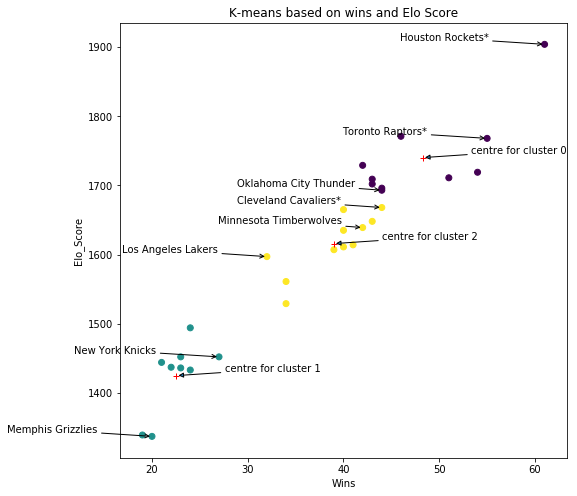

In [18]:
def simple_cluster(Stats, ifSub=False, num_clusters=2):  
    """ Apply kmeans to the input team feature matrixes and 
        plot the result(with representative teams annotated)
    
    Args:
        Stats (pd.DataFrame): DataFrame of each team's features
        ifSub (Boolean): for subplot consideration
        num_clusters (Number): number of clusters centres
    """
    X = np.asarray(Stats)
    
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(Stats)
    y_pred = kmeans.labels_
    centres = kmeans.cluster_centers_
    if(ifSub==False):
        # Print Information for each Cluster
        for i in range(0, centres.shape[0]):
            print ('#Cluster ', i, 'Centre: ', centres[i])
            y_ = [a==i for a in y_pred]
            for index, row in Stats[y_].iterrows():
                print (index, '('+str(row['W'])+', '+str(row['Elo_Score'])+')')
            print ()
   
        plt.figure(figsize=(8, 8))
    
    
    # Annotate all the centres of clusters
    dis = (Stats.loc[:, 'W'].max() - Stats.loc[:, 'W'].min()) * 0.12 # Line Length for Arrows
    for i in range(0, centres.shape[0]):
        plt.annotate('centre for cluster '+str(i), xy=(centres[i,0], centres[i,1]), xycoords='data',
                xytext=(centres[i,0]+dis, centres[i,1]+dis), textcoords='data',
                arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3"),)
    
    # Annotate some representative Teams
    certain_team_list = ['Houston Rockets*', 'Toronto Raptors*', 'Oklahoma City Thunder', 'Memphis Grizzlies', 'Minnesota Timberwolves', 'New York Knicks', 'Los Angeles Lakers', 'Cleveland Cavaliers*'] 

    for team in certain_team_list:
        wins = Stats.loc[team,'W']
        score = Stats.loc[team, 'Elo_Score']
        plt.annotate(team, xy=(wins, score), xycoords='data',
                xytext=(wins-3*dis, score+dis), textcoords='data',
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),)
    
    
    plt.plot(centres[:,0],centres[:,1], 'r+')
    plt.scatter(Stats.loc[:,'W'], Stats.loc[:,'Elo_Score'], c=y_pred)
            
Major_Stats = Team_Vectors.loc[:, [ 'W', 'Elo_Score']]
Major_Stats


simple_cluster(Major_Stats, num_clusters=3)
plt.xlabel("Wins")
plt.ylabel("Elo_Score")
plt.title("K-means based on wins and Elo Score")


Standardize the data First to Balance the influence of each attribute on distance.
$$ z = \frac{x - u}{\varrho} $$

#Cluster  0 Centre:  [0.2753909  0.31846323]
New Orleans Pelicans (0.5106586173224179, 0.7900424929638031)
Denver Nuggets (0.24803418555660306, 0.2536833693003038)
Minnesota Timberwolves (0.4231171400671463, 0.2826757543631956)
Cleveland Cavaliers* (0.5982000945776895, 0.4928705460691616)
Los Angeles Clippers (0.24803418555660306, 0.4711262572719927)
Charlotte Hornets (-0.2772146779750265, -0.2826757543631956)
Oklahoma City Thunder (0.5982000945776895, 0.6740729527122357)
Philadelphia 76ers* (0.5106586173224179, 0.7393058191037424)
Washington Wizards (0.3355756628118747, 0.1014733477201215)
Indiana Pacers* (0.5982000945776895, 0.6958172415094046)
Los Angeles Lakers (-0.4522976324855697, -0.021744288797168894)
Milwaukee Bucks (0.16049270830133147, 0.05073667386006075)
Miami Heat (0.24803418555660306, 0.07972905892295261)
San Antonio Spurs (0.5106586173224179, 0.3479086207547023)
Utah Jazz (0.4231171400671463, 0.9350044182782624)
Detroit Pistons (-0.2772146779750265, -0.5146148348663304)

Text(0.5,1,'K-means based on standardized wins and Elo Score')

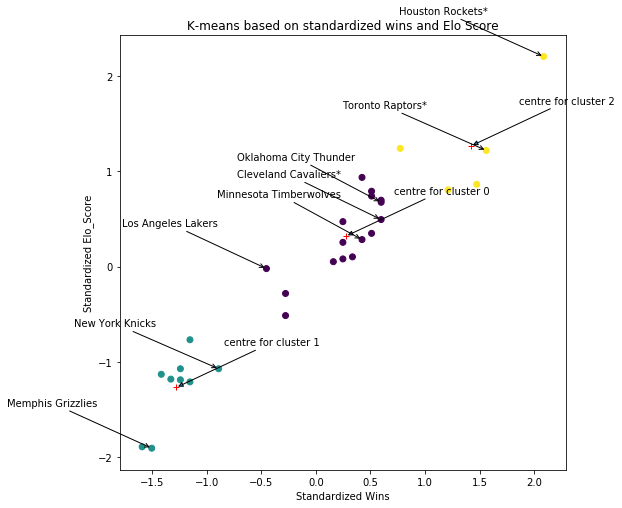

In [19]:
Standard_Stats = 1.0*(Major_Stats - Major_Stats.mean())/Major_Stats.std()
simple_cluster(Standard_Stats, num_clusters=3)
plt.xlabel("Standardized Wins")
plt.ylabel("Standardized Elo_Score")
plt.title("K-means based on standardized wins and Elo Score")

Put It Together

Text(0.5,1,'K-means based on standardized wins and Elo Score')

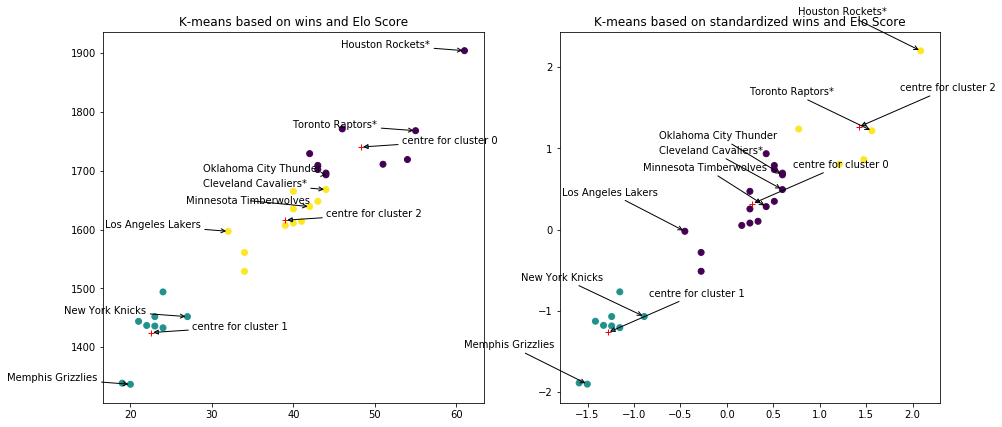

In [20]:
plt.figure(figsize=(15, 15))

plt.subplot(221)
simple_cluster(Major_Stats, ifSub=True, num_clusters=3)
plt.title("K-means based on wins and Elo Score")

plt.subplot(222)
simple_cluster(Standard_Stats, ifSub=True, num_clusters=3)
plt.title("K-means based on standardized wins and Elo Score")

# plt.show()

Text(0.5,1,'K-means based on standardized wins and Elo Score, 4 clusters')

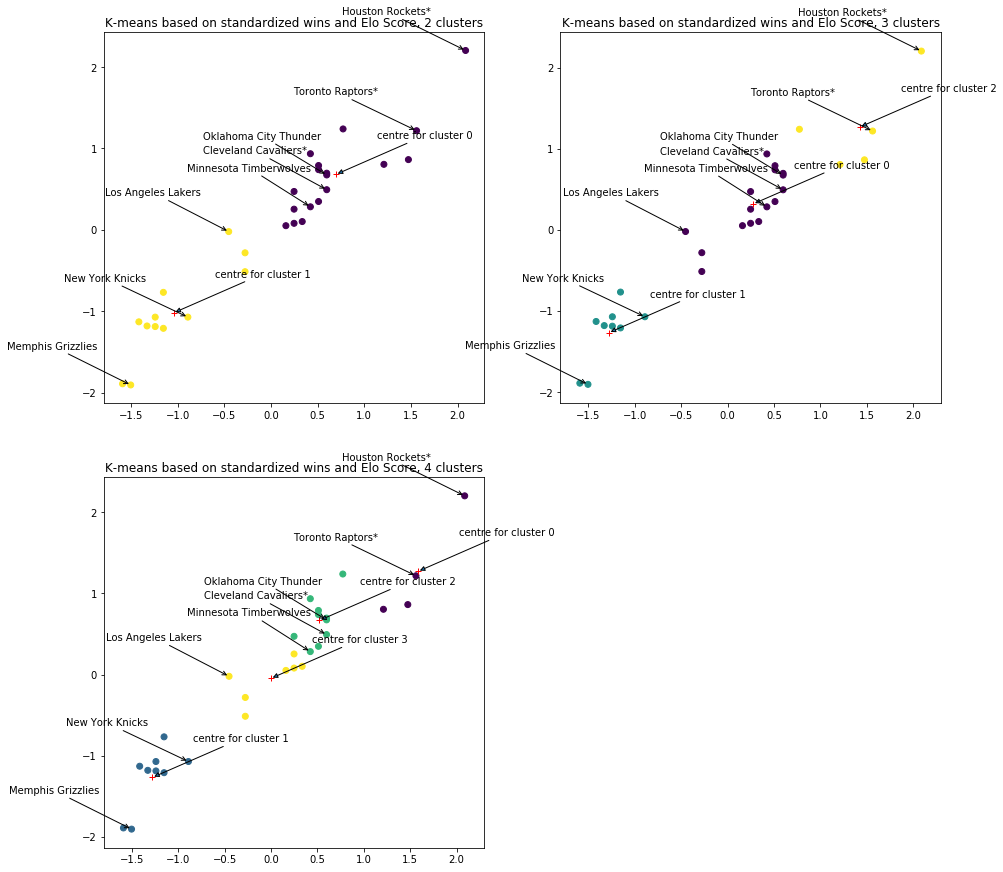

In [21]:
plt.figure(figsize=(15, 15))

plt.subplot(221)
simple_cluster(Standard_Stats, ifSub=True, num_clusters=2)
plt.title("K-means based on standardized wins and Elo Score, 2 clusters")

plt.subplot(222)
simple_cluster(Standard_Stats, ifSub=True, num_clusters=3)
plt.title("K-means based on standardized wins and Elo Score, 3 clusters")

plt.subplot(223)
simple_cluster(Standard_Stats, ifSub=True, num_clusters=4)
plt.title("K-means based on standardized wins and Elo Score, 4 clusters")

### Clustering with all attributes

Then we make use of all 65 attributes gathered.

In [22]:
def cluster(Stats, num_clusters=2):
    """ Apply kmeans to the input team feature matrixes and simple output and 
        plot the result(with representative teams annotated)
    
    Args:
        Stats (pd.DataFrame): DataFrame of each team's features
        num_clusters (Number): number of clusters centres
    """
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(Stats)
    y_pred = kmeans.labels_
    centres = kmeans.cluster_centers_
    
    # Print Information for each Cluster
    for i in range(0, centres.shape[0]):
        print ('###### Cluster ', i, '######')
        y_ = [a==i for a in y_pred]
        for index, row in Stats[y_].iterrows():
#             print (index, '('+str(row['W'])+', '+str(row['Elo_Score'])+')')
            print(index)

    plt.figure(figsize=(8, 8))
    
    
    # Annotate some representative Teams
    dis = (Stats.loc[:, 'W'].max() - Stats.loc[:, 'W'].min()) * 0.12 # Line Length for Arrows

    certain_team_list = ['Houston Rockets*', 'Toronto Raptors*', 'Oklahoma City Thunder', 'Memphis Grizzlies', 'Minnesota Timberwolves', 'New York Knicks', 'Los Angeles Lakers', 'Cleveland Cavaliers*'] 
#     print (Stats.loc['Houston Rockets*','W'])

    for team in certain_team_list:
        wins = Stats.loc[team,'W']
        score = Stats.loc[team, 'Elo_Score']
        plt.annotate(team, xy=(wins, score), xycoords='data',
                xytext=(wins-3*dis, score+dis), textcoords='data',
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),)
    
    
    plt.scatter(Stats.loc[:,'W'], Stats.loc[:,'Elo_Score'], c=y_pred)

###### Cluster  0 ######
New Orleans Pelicans
Denver Nuggets
Minnesota Timberwolves
Cleveland Cavaliers*
Los Angeles Clippers
Charlotte Hornets
Oklahoma City Thunder
Washington Wizards
Indiana Pacers*
Milwaukee Bucks
###### Cluster  1 ######
Houston Rockets*
Golden State Warriors*
Toronto Raptors*
Philadelphia 76ers*
Portland Trail Blazers
Miami Heat
Boston Celtics*
San Antonio Spurs
Utah Jazz
###### Cluster  2 ######
Los Angeles Lakers
Brooklyn Nets
New York Knicks
Phoenix Suns
Atlanta Hawks
Chicago Bulls
Detroit Pistons
Orlando Magic
Dallas Mavericks
Sacramento Kings
Memphis Grizzlies


Text(0.5,1,'K-means based on all standardized features generated')

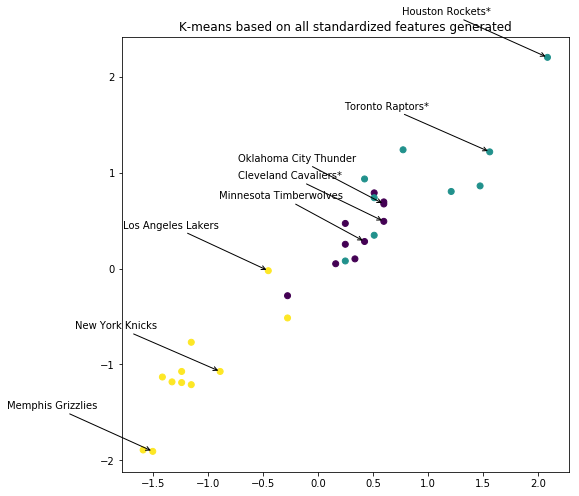

In [23]:
# Here we must standardized the DataFrame first, cause the Elo Score is comparatively too large
# And most features are based on percentage, so without standardization, 
# the K-means result will be mainly based on Elo Score attribute
Standard_Team_Vectors = 1.0*(Team_Vectors - Team_Vectors.mean())/Team_Vectors.std()
cluster(Standard_Team_Vectors, num_clusters=3)
plt.title("K-means based on all standardized features generated")

## Summary and references

This tutorial demonstrate a basic process for obtaining, processing, and analyzing NBA datasets. Based on official datasets collected, Elo Rank system and k-means clustering method are applied to group all NBA's 30 teams and evaluate their competence level.

1. Data analytics have made the NBA unrecognizable: https://qz.com/1104922/data-analytics-have-revolutionized-the-nba/
2. Exploring Golden State Warriors with Data Science: http://blog.thedevmasters.com/blog/exploring-nba-data-python
3. Official NBA Stats: https://stats.nba.com
4. Elo Rating System: https://en.wikipedia.org/wiki/Elo_rating_system
5. K-means Clustering: https://en.wikipedia.org/wiki/K-means_clustering
6. sklearn KMeans document: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.fit_predict